# First Start

In [1]:
from datetime import datetime
from math import cos, sin
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
station_metadata = pd.read_csv('data/ground_measures_metadata.csv')
grid_geodata = gpd.read_file('data/grid_cells.geojson')
submission_format = pd.read_csv('data/submission_format.csv')
train_labels = pd.read_csv('data/train_labels.csv')

measures_test = pd.read_csv('data/ground_measures_test.csv')
measures_train = pd.read_csv('data/ground_measures_train.csv')

Data:
* Station Metadata: Name, Coordinates and Altitude of Stations
* Grid Geodata: Grid Cell (Area) Coordinates (SWE in these Areas are to be predicted)
* Submission Format: Includes all Cells that have to be predicted with the submission dates and format
* Train Labels: Training Data for Grid Cells
* Measures Train and Test: Data of actual Measurement Stations (Locations have to be linked to Grid Cells)
* Measures Train: 2013 - 2019
* Measures Test: 2020 - Mid 2021

Additional Data Source like Satellite Images can be used (https://www.drivendata.org/competitions/86/competition-reclamation-snow-water-dev/page/417/)

First thoughts:
The goal is to predict the SWE data for 1km x 1km Resolution (for given Grid Cells found in grid_geodata).
First, we predict the Measurement Data of the Stations and calculate the Position relative to the Grid Cells.
To Predict the Cell Data we can use the Measurement Data (Stations and Satellite Data) and there relative Position to the cells.
The train_labels.csv can be used for training (98% NaN)...


In [3]:
def get_middle(pg):
    xy = pg.exterior.coords.xy
    x, y = xy[0], xy[1]
    x1, x2 = x[0], x[1]
    y1, y2 = y[0], y[1]
    mid_x = (x1 + x2) / 2
    mid_y = (y1 + y2) / 2
    assert x1 <= mid_x <= x2, "Something is off: x"
    assert y1 <= mid_y <= y2, "Something is off: y"
    return mid_x, mid_y

In [4]:
train_labels["location"] = grid_geodata[grid_geodata['cell_id'].isin(train_labels['cell_id'])].reset_index()["geometry"]

In [5]:
train_labels["location"][0].exterior.coords.xy

(array('d', [-118.7189531728198, -118.7189531728198, -118.727936325661, -118.727936325661, -118.7189531728198]),
 array('d', [37.07419231005138, 37.08135922968016, 37.08135922968016, 37.07419231005138, 37.07419231005138]))

In [6]:
train_labels["location"] = train_labels["location"].apply(get_middle)

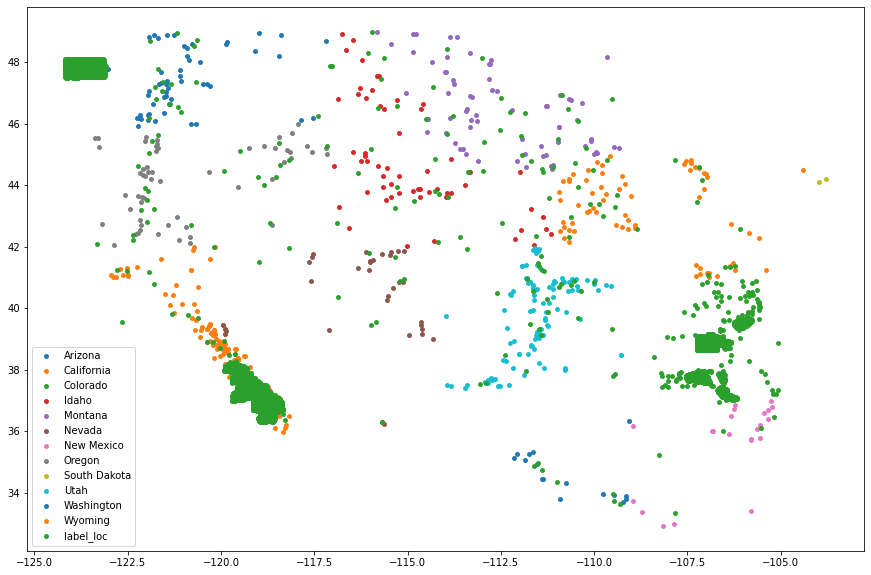

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))
for g in np.unique(station_metadata["state"]):
    ix = np.where(station_metadata["state"] == g)
    x = station_metadata.iloc[ix]["longitude"]
    y = station_metadata.iloc[ix]["latitude"]
    ax.scatter(x, y, label=g, s=15)
labels_x = train_labels["location"].apply(lambda x: x[0])
labels_y = train_labels["location"].apply(lambda x: x[1])
ax.scatter(labels_x, labels_y, label="label_loc", s=15)

ax.legend()
plt.show()

### Imputing and building of x_y for stations

In [8]:
measures_train.iloc[:, 1:] = measures_train.iloc[:, 1:].astype(float).interpolate(method="linear", axis=1,
                                                                                  limit_direction="both")
measures_test.iloc[:, 1:] = measures_test.iloc[:, 1:].astype(float).interpolate(method="linear", axis=1)
measures_train.dropna(inplace=True)
measures_test.dropna(inplace=True)

In [9]:
x_train = []
y_train = []

x_test = []
y_test = []

In [10]:
station_meta = {}
for oi, r in station_metadata.iterrows():
    station_meta[r[0]] = {
        'elev': r['elevation_m'],
        'lat': r['latitude'],
        'long': r['longitude']
    }

In [11]:
def df_to_xy(dataframe: pd.DataFrame):
    x = []
    y = []
    for oi, j in dataframe.iterrows():
        lat = station_meta[j[0]]['lat']
        long = station_meta[j[0]]['long']
        elev = station_meta[j[0]]['elev']
        for k, e in j.items():
            if k == 'Unnamed: 0':
                continue
            dt = datetime.strptime(k, '%Y-%m-%d')
            date = dt.date()
            x.append(np.array([elev, lat, long, date.year - 2000, date.month, date.day]))
            y.append(e)

    return np.array(x), np.array(y)

In [12]:
x_train, y_train = df_to_xy(measures_train)
x_test, y_test = df_to_xy(measures_test)

Distribution of SWE by Date


Text(0, 0.5, 'SWE')

<Figure size 432x288 with 0 Axes>

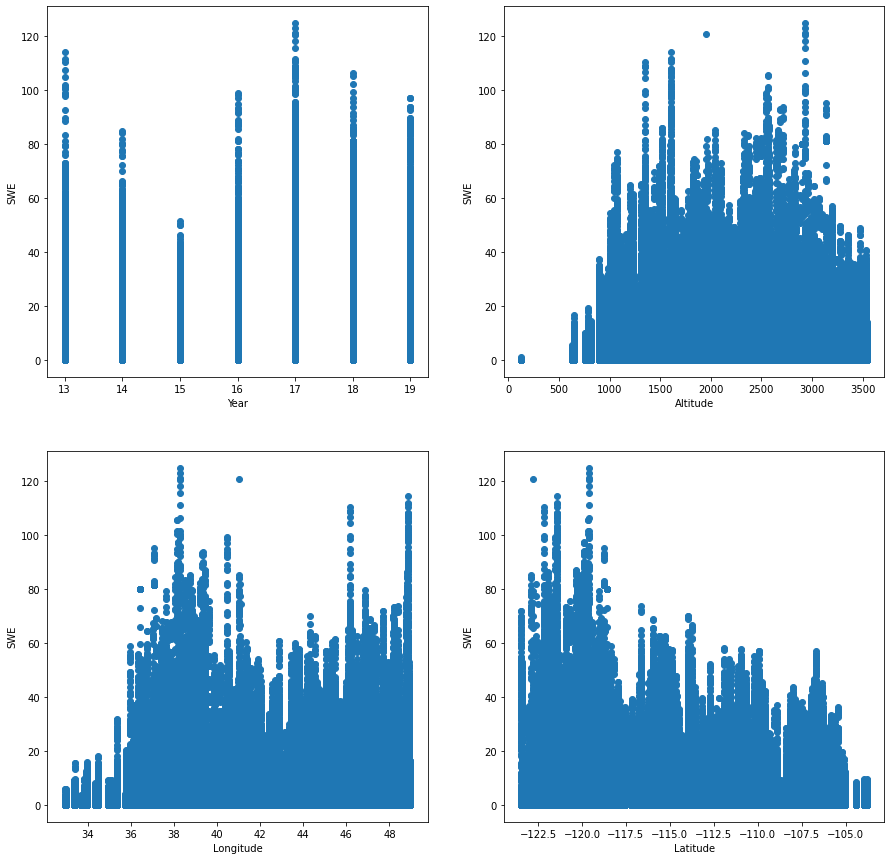

In [13]:
plt.figure()
print('Distribution of SWE by Date')
f, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(15, 15))
ax1.set_xlabel('Year')
ax1.set_ylabel('SWE')
ax1.scatter(x_train[:, 3], y_train)
ax2.set_xlabel('Altitude')
ax2.set_ylabel('SWE')
ax2.scatter(x_train[:, 0], y_train)
ax3.scatter(x_train[:, 1], y_train)
ax4.scatter(x_train[:, 2], y_train)
ax3.set_xlabel('Longitude')
ax4.set_xlabel('Latitude')
ax3.set_ylabel('SWE')
ax4.set_ylabel('SWE')

### Scaling Data

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [15]:
x_train

array([[ 1.88976000e+03,  4.12370000e+01, -1.20792000e+02,
         1.30000000e+01,  1.00000000e+00,  1.00000000e+00],
       [ 1.88976000e+03,  4.12370000e+01, -1.20792000e+02,
         1.30000000e+01,  1.00000000e+00,  8.00000000e+00],
       [ 1.88976000e+03,  4.12370000e+01, -1.20792000e+02,
         1.30000000e+01,  1.00000000e+00,  1.50000000e+01],
       ...,
       [ 1.07289600e+03,  4.87629204e+01, -1.21698227e+02,
         1.90000000e+01,  1.20000000e+01,  1.70000000e+01],
       [ 1.07289600e+03,  4.87629204e+01, -1.21698227e+02,
         1.90000000e+01,  1.20000000e+01,  2.40000000e+01],
       [ 1.07289600e+03,  4.87629204e+01, -1.21698227e+02,
         1.90000000e+01,  1.20000000e+01,  3.10000000e+01]])

In [16]:
# Elevation, Long, Lat, Month and Day: MinMax Scaling
def scaler(xs, initial=False):
    global minmax_1, minmax_2
    if initial:
        minmax_1 = MinMaxScaler().fit(xs[:, :3])
        minmax_2 = MinMaxScaler().fit(xs[:, 4:])
    xs[:, :3] = minmax_1.transform(xs[:, :3])
    xs[:, 4:] = minmax_2.transform(xs[:, 4:])
    return xs

x_test = scaler(x_test, True)
x_train = scaler(x_train)

In [17]:
x_train[:]

array([[ 0.51607145,  0.51790386,  0.13551034, 13.        ,  0.        ,
         0.        ],
       [ 0.51607145,  0.51790386,  0.13551034, 13.        ,  0.        ,
         0.23333333],
       [ 0.51607145,  0.51790386,  0.13551034, 13.        ,  0.        ,
         0.46666667],
       ...,
       [ 0.27678572,  0.98677292,  0.08943856, 19.        ,  1.        ,
         0.53333333],
       [ 0.27678572,  0.98677292,  0.08943856, 19.        ,  1.        ,
         0.76666667],
       [ 0.27678572,  0.98677292,  0.08943856, 19.        ,  1.        ,
         1.        ]])

### First Model for Station Data Forcasting

In [18]:
model = keras.Sequential([
    layers.Dense(64),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])
model.compile(loss='mean_squared_error',
              optimizer='rmsprop')

In [19]:
model.fit(x_train, y_train, epochs=20)

Train on 148674 samples
Epoch 1/20
148674/148674 [==============================] - 14s 92us/sample - loss: 131.0801
Epoch 2/20
148674/148674 [==============================] - 13s 87us/sample - loss: 113.1032
Epoch 3/20
148674/148674 [==============================] - 13s 88us/sample - loss: 104.5216
Epoch 4/20
148674/148674 [==============================] - 13s 88us/sample - loss: 99.7616
Epoch 5/20
148674/148674 [==============================] - 13s 87us/sample - loss: 97.6506
Epoch 6/20
148674/148674 [==============================] - 13s 88us/sample - loss: 96.5903
Epoch 7/20
148674/148674 [==============================] - 13s 89us/sample - loss: 95.8470
Epoch 8/20
148674/148674 [==============================] - 13s 89us/sample - loss: 95.1254
Epoch 9/20
148674/148674 [==============================] - 13s 89us/sample - loss: 94.8451
Epoch 10/20
148674/148674 [==============================] - 13s 89us/sample - loss: 94.8193
Epoch 11/20
148674/148674 [=========================

In [20]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model.predict(x_test)
print('RMSE: ')
print(mean_squared_error(y_test, y_pred, squared=False))

print('\nR2:')
print(r2_score(y_test, y_pred))

RMSE: 
9.146625834934488

R2:
0.23490925231834514


### Trying to map Stations to Grid Cells
Creating Neighbor Map:
{
'cell_id': [(station_name, abs_distance, distance_long, distance_lat), ...]
}

In [21]:
neighbors_map = {}
neighbors_n = 3
for i, r in train_labels.iterrows():

    long = r['location'][0]
    lat = r['location'][1]
    filter_distance = 0.5
    filtered_stations = station_metadata[(station_metadata['longitude'] >= long - filter_distance) & (station_metadata['longitude'] <= long + filter_distance)]
    filtered_stations = filtered_stations[(filtered_stations['latitude'] >= lat - filter_distance) & (filtered_stations['latitude'] <= lat + filter_distance)]

    def build_neighbor_dict(stations):
        neighbor_dict = {}
        for ii, s in stations.iterrows():
            diff_long = s['longitude'] - r['location'][0]
            diff_lat = s['latitude'] - r['location'][1]
            neighbor_dict[s[0]] = [abs(diff_long) + abs(diff_lat), diff_long, diff_lat, s['longitude'], s['latitude'], s['elevation_m']]
        return neighbor_dict

    neighbor_dict = build_neighbor_dict(filtered_stations)
    if len(neighbor_dict) < 3:
        neighbor_dict = build_neighbor_dict(station_metadata)

    sorted_neighbors = sorted(neighbor_dict.items(), key=lambda sx: abs(sx[1][0]))

    neighbors_map[r['cell_id']] = [(x[0], x[1][0], x[1][1], x[1][2], x[1][3], x[1][4], x[1][5]) for x in sorted_neighbors[:neighbors_n]]
    print('%s/%s' % (i+1, len(train_labels)), end='\r')

In [22]:
model.predict([[1.,1.,1.,1.,1.,1.], [1.,1.,1.,1.,1.,1.]])

array([[9.725868],
       [9.725868]], dtype=float32)

In [23]:
def df_neighbors_to_xy(df, neighbors_dict, model, scaler_func):
    df = df.drop(['location'], axis=1)
    x = []
    y = []
    ii = 1
    i_all = df.shape[0] * df.shape[1]
    for i, r in df.iterrows():
        cell_id = r['cell_id']
        for k, e in r.iteritems():
            ii += 1
            if k == 'cell_id':
                continue

            if e is None or e == np.nan:
                continue

            try:
                dt = datetime.strptime(k, '%Y-%m-%d')
            except ValueError:
                continue
            date = dt.date()

            neighbor_ll = np.array(neighbors_map[cell_id])
            x_to_pred = []
            neighbor_data = []
            for neighbor in neighbor_ll:
                neighbor_data.append([neighbor[1], neighbor[2], neighbor[3]])
                x_to_pred.append(np.array([neighbor[6], neighbor[5], neighbor[4], date.year - 2000, date.month, date.day]))

            x_to_pred = scaler_func(np.array(x_to_pred))
            predictions = model.predict(x_to_pred)

            x.append([predictions[fi][0], neighbor_data[fi][0], neighbor_data[fi][1], neighbor_data[fi][2]] for fi in range(len(neighbor_data)))
            y.append(e)

        print('%s/%s' % (ii, i_all), end='\r')
    return x, y

In [24]:
train_labels

,cell_id,2013-01-01,2013-01-08,2013-01-15,2013-01-22,2013-01-29,2013-02-05,2013-02-12,2013-02-19,2013-02-26,...,2019-06-14,2019-06-18,2019-06-24,2019-06-25,2019-12-03,2019-12-10,2019-12-17,2019-12-24,2019-12-31,location
0,0003f387-71c4-48f6-b2b0-d853bd4f0aba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-118.7189531728198, 37.07777576986577)"
1,000617d8-8c14-43e2-b708-7e3a69fe3cc3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-107.0767870906308, 37.78397333401607)"
2,000ba8d9-d6d5-48da-84a2-1fa54951fae1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-119.3208244131799, 37.43527393760802)"
3,0017d1c4-64cb-426d-9158-3f6521d2dd22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-119.4286222472742, 37.24243563636779)"
4,0020c632-3d5c-4509-b4ee-6b63a89bf2ff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-118.8986162296437, 36.85527598313992)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10873,ffdc53d2-5565-496a-b849-4fcf33f33a36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-119.09624559215, 37.049102672209195)"
10874,ffdfb5a4-91a0-41a9-a4d5-501b04ef6326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-118.6201384915667, 37.1207650916254)"
10875,ffe43514-2c92-43b6-bd84-d183806aca65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-123.4979904843356, 47.90432872112956)"
10876,fff95195-ccc9-40b7-b302-a0d8570c86bc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-123.3722263445589, 47.73543687890145)"


In [ ]:
#x_label_train, y_label_train = df_neighbors_to_xy(train_labels, neighbors_map, model, scaler)
